In [1]:
!pip install transformers
!python -m pip install -U xgboost

     |████████████████████████████████| 1.8MB 8.6MB/s 
     |████████████████████████████████| 890kB 31.1MB/s 
     |████████████████████████████████| 2.9MB 43.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=3e1d12921664c37e501987d06b6c27825a9bec29643be5bae72cd729365315f0
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 157.5MB 42kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [2]:
# general libraries
#imports
from os.path import join as pathjoin;
from os import listdir;
import os;
import re;
import json;
import matplotlib.pyplot as plt;
import pandas as pd;
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
import numpy
import sklearn.pipeline
from gensim.models import KeyedVectors
from sklearn.model_selection import GridSearchCV
import math,glob

from mlxtend.regressor import StackingRegressor
from sklearn import linear_model
from sklearn.ensemble.forest import RandomForestRegressor as RFR
from sklearn.ensemble.forest import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn import neural_network
import xgboost as xgb


from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random

random.seed(42)
np.random.seed(42)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# bert related libraries
import torch
import tensorflow as tf
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel, AutoModelWithLMHead

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
base_path = '/content/gdrive/My Drive/Mestrado/Bert/Portugues/'
dev_data_path = pathjoin(base_path,'crf_baseline/train_cut')
eval_data_path = pathjoin(base_path,'crf_baseline/test_cut')

In [6]:
def loadConversations(path):
    conversations = []
    for f in glob.glob(path + '/*.log.json'):
        json_obj = json.load(open(pathjoin(path,f), encoding='utf-8'))
        json_obj['file_name'] = f
        conversations.append(json_obj)
    return conversations

In [7]:
def SetMajorityVoteAndDistribution(conversations, threshold):
    for c in conversations:
        for t in c['turns']:
            count={}
            count['O']=0
            count['T']=0
            count['X']=0
            hasAnnotations = False
            for a in t['annotations']:
                hasAnnotations = True
                count[a['breakdown']] +=1
            del t['annotations']
            if hasAnnotations:
                #distribution
                t['O'] = count['O']*1.0 / (count['O'] + count['T'] + count['X'])
                t['T'] = count['T']*1.0 / (count['O'] + count['T'] + count['X'])
                t['X'] = count['X']*1.0 / (count['O'] + count['T'] + count['X']) 
                #majorityVoting
                t['class'] = 'O'
                t['class'] = 'X' if t['X']>=t['T'] and t['X']>=t['O'] and t['X']>=threshold else t['class']
                t['class'] = 'T' if t['T']>=t['O'] and t['T']>=t['X'] and t['T']>=threshold else t['class']
                t['class'] = 'O' if t['O']>=t['T'] and t['O']>=t['X'] and t['O']>=threshold else t['class']
                
    return conversations

In [8]:
def resultArray(pipeline, test, testPred):
    #test.sort_values(['file_name', 'user-index'], ascending=[True, True])
    result ={}
    data = {}
    data['turns'] = []
    size = test.shape[0]
    predictedValues = pipeline.predict(testPred)
    predictedProbas = pipeline.predict_proba(testPred)
    for i in range(size):
        data['dialogue-id'] = test.iloc[i]['dialogue-id']
        result[data['dialogue-id']] = data
        predictedValue = scoreToLabel(predictedValues[i])
        predictedProba = predictedProbas[i]
        
        turn ={}
        turn['turn-index'] = int(test.iloc[i]['system-index'])
        turn['labels'] = []
        
        label ={}
        label['breakdown'] = predictedValue
        label['prob-O'] = predictedProba[0]
        label['prob-T'] = 0
        label['prob-X'] = predictedProba[1] 
        
        turn['labels'].append(label)        
        data['turns'].append(turn)
        if  i == size-1 or test.iloc[i]['file_name'] != test.iloc[i+1]['file_name']:
            data = {}
            data['turns'] = []
    return result

In [9]:
def ConversationClassCount(conversations):
    count={}
    count['O']=0
    count['T']=0
    count['X']=0
    for c in conversations:
        for t in c['turns']:
            if 'class' in t:
                count[t['class']] += 1
    return count

In [10]:
def scoreToLabel(score):
    score_float = float(score)
    if score_float<0.4:
        return 'O'
    elif score_float <0.8:
        return 'T'
    else:
        return 'X'

**Métodos de avaliação**

In [11]:
def calc_distribution(annotations) :
    count_O = 0
    count_T = 0
    count_X = 0

    for annotation in annotations:
        if annotation['breakdown'] == 'O':
            count_O += 1
        elif annotation['breakdown'] == 'T':
            count_T += 1
        elif annotation['breakdown'] == 'X':
            count_X += 1

    prob_O = count_O*1.0 / (count_O + count_T + count_X)
    prob_T = count_T*1.0 / (count_O + count_T + count_X)
    prob_X = count_X*1.0 / (count_O + count_T + count_X)

    return [prob_O, prob_T, prob_X]

In [12]:
def majority_label(prob_O, prob_T, prob_X, threshold):

    if prob_O >= prob_T and prob_O >= prob_X and prob_O >= threshold:
        return "O"
    elif prob_T >= prob_O and prob_T >= prob_X and prob_T >= threshold:
        return "T"
    elif prob_X >= prob_T and prob_X >= prob_O and prob_X >= threshold:
        return "X"
    else:
        return "O"

In [13]:
def majority_label_lenient(prob_O, prob_T, prob_X, threshold):

    if prob_O >= prob_T + prob_X and prob_O >= threshold:
        return "O_l"
    elif prob_T + prob_X >= prob_O and prob_T + prob_X >= threshold:
        return "X_l"
    else:
        return "O_l"

In [14]:
def kld(p, q):
    k = 0.0
    for i in range(len(p)):
        if p[i] > 0:
            k += p[i] * (math.log(p[i]/q[i],2))
    return k

In [15]:
def jsd(p, q):
    m = []
    for i in range(len(p)):
        m.append((p[i]+q[i])/2.0)

    return (kld(p,m) + kld(q,m)) / 2.0

In [16]:
def mse(p, q):
    total = 0.0

    for i in range(len(p)):
        total += pow(p[i] - q[i],2)

    return total / len(p)

In [17]:
def evaluationAsDict(data_path,eval_data,threshold):

    file_num = 0
    label_num = 0

    correct_num = 0
    incorrect_num = 0

    predO_ansO = 0
    predO_ansT = 0
    predO_ansX = 0
    predT_ansO = 0
    predT_ansT = 0
    predT_ansX = 0
    predX_ansO = 0
    predX_ansT = 0
    predX_ansX = 0

    predO_ansO_l = 0
    predO_ansX_l = 0
    predT_ansO_l = 0
    predT_ansX_l = 0
    predX_ansO_l = 0
    predX_ansX_l = 0

    jsd_O_T_X_sum = 0.0
    jsd_O_TX_sum = 0.0
    jsd_OT_X_sum = 0.0
    mse_O_T_X_sum = 0.0
    mse_O_TX_sum = 0.0
    mse_OT_X_sum = 0.0

    pred_dist_list = []
    ans_dist_list = []

    #parser = argparse.ArgumentParser()
    #parser.add_argument('-p', dest='datapath', action='store', metavar='TESTDIR', required=True,
                        #help='テスト用の対話データが入ったディレクトリ')
    #parser.add_argument('-o', dest='evalpath', action='store', metavar='EVALDIR', required=True,
                        #help='評価用データが入ったディレクトリ')
    #parser.add_argument('-t', dest='threshold', action='store', metavar='THRESHOLD', required=False,
                        #help='正解ラベルを決定するためのしきい値')

    #args = parser.parse_args()

    #data_path = args.datapath
    #eval_path = args.evalpath

    #threshold = 0.0
    #if args.threshold != None:
    #    threshold = float(args.threshold)

    #if not data_path.endswith('/') or not data_path.endswith('\\'):
        #data_path += '/'
    #if not eval_path.endswith('/') or not eval_path.endswith('\\'):
        #eval_path += '/'

    data_files = glob.glob(data_path + '/*log.json')
    
    for f in data_files:
    #for data_json in data_files:
        file_num += 1

        data_fp = open(f, "r")
        data_json = json.load(data_fp)
        data_fp.close()

        dlg_id = data_json["dialogue-id"]
        #eval_fp = open(eval_path + dlg_id + ".labels.json", "r")
        #eval_json = json.load(eval_fp)
        #eval_fp.close()
        
        eval_json = eval_data[dlg_id]
        #print(dlg_id)
        eval_index = 0
        for turn in data_json['turns']:
            if turn['speaker'] == "U" or turn['annotations']==[]:  # modified Sep 17 2017
                continue

            label_num += 1

            ans_prob_dist = calc_distribution(turn['annotations'])
            ans_dist_list.append(ans_prob_dist)
            ans_label = majority_label(ans_prob_dist[0], ans_prob_dist[1], ans_prob_dist[2], threshold)

            ans_label_l = majority_label_lenient(ans_prob_dist[0], ans_prob_dist[1], ans_prob_dist[2], threshold)

            #print(f)
            target_label = eval_json['turns'][eval_index]['labels'][0]
            
            #print(str(ans_label)+','+str(target_label['breakdown'])+','+ str(turn['turn-index'])+','+ str(eval_json['turns'][eval_index]['turn-index']))

            pred_prob_dist = [float(target_label['prob-O']), float(target_label['prob-T']), float(target_label['prob-X'])]
            pred_dist_list.append(pred_prob_dist)

            jsd_O_T_X_sum += jsd(ans_prob_dist,pred_prob_dist)
            jsd_O_TX_sum += jsd([ans_prob_dist[0],ans_prob_dist[1] + ans_prob_dist[2]],[pred_prob_dist[0],pred_prob_dist[1] + pred_prob_dist[2]])
            jsd_OT_X_sum += jsd([ans_prob_dist[0] + ans_prob_dist[1],ans_prob_dist[2]],[pred_prob_dist[0] + pred_prob_dist[1] ,pred_prob_dist[2]])

            mse_O_T_X_sum += mse(ans_prob_dist,pred_prob_dist)
            mse_O_TX_sum += mse([ans_prob_dist[0],ans_prob_dist[1] + ans_prob_dist[2]],[pred_prob_dist[0],pred_prob_dist[1] + pred_prob_dist[2]])
            mse_OT_X_sum += mse([ans_prob_dist[0] + ans_prob_dist[1],ans_prob_dist[2]],[pred_prob_dist[0] + pred_prob_dist[1] ,pred_prob_dist[2]])

            pred_label = target_label['breakdown']
            eval_index += 1

            if pred_label == ans_label:
                correct_num += 1
            else:
                incorrect_num += 1

            if pred_label == "O":
                if ans_label == "O":
                    predO_ansO += 1
                elif ans_label == "T":
                    predO_ansT += 1
                elif ans_label == "X":
                    predO_ansX += 1
            elif pred_label == "T":
                if ans_label == "O":
                    predT_ansO += 1
                elif ans_label == "T":
                    predT_ansT += 1
                elif ans_label == "X":
                    predT_ansX += 1
            elif pred_label == "X":
                if ans_label == "O":
                    predX_ansO += 1
                elif ans_label == "T":
                    predX_ansT += 1
                elif ans_label == "X":
                    predX_ansX += 1

            #lenient
            if pred_label == "O":
                if ans_label_l == "O_l":
                    predO_ansO_l += 1
                elif ans_label_l == "X_l":
                    predO_ansX_l += 1
            elif pred_label == "T":
                if ans_label_l == "O_l":
                    predT_ansO_l += 1
                elif ans_label_l == "X_l":
                    predT_ansX_l += 1
            elif pred_label == "X":
                if ans_label_l == "O_l":
                    predX_ansO_l += 1
                elif ans_label_l == "X_l":
                    predX_ansX_l += 1


#     print correct_num
#     print incorrect_num
#
#     print predO_ansO
#     print predO_ansT
#     print predO_ansX
#     print predT_ansO
#     print predT_ansT
#     print predT_ansX
#     print predX_ansO
#     print predX_ansT
#     print predX_ansX


    #print str(predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l + predO_ansX_l + predO_ansO_l)
    
    print("######### Data Stats #########")
    print("File Num : \t\t" + str(file_num))
    print("System Utterance Num : \t" + str(label_num))
    print("O Label Num : \t\t" + str(predO_ansO + predT_ansO + predX_ansO))
    print("T Label Num : \t\t" + str(predO_ansT + predT_ansT + predX_ansT))
    print("X Label Num : \t\t" + str(predO_ansX + predT_ansX + predX_ansX))
    print("")

    print("######### Results #########")
    print("Accuracy : \t\t%4f" % ((correct_num*1.0) / (correct_num + incorrect_num)) + " (" + str(correct_num) + "/" + str(correct_num + incorrect_num) + ")\n")

    precision_s = 0.0
    recall_s = 0.0
    fmeasure_s = 0.0

    if predX_ansX > 0:
        if (predX_ansO + predX_ansT + predX_ansX) > 0:
            precision_s = predX_ansX*1.0 / (predX_ansO + predX_ansT + predX_ansX)
        if (predO_ansX + predT_ansX + predX_ansX) > 0:
            recall_s = predX_ansX*1.0 / (predO_ansX + predT_ansX + predX_ansX)

    if precision_s > 0 and recall_s > 0:
        fmeasure_s = (2*precision_s*recall_s)/(precision_s + recall_s)

    print("Precision (X) : \t%4f" % (precision_s) + " (" + str(predX_ansX) + "/" + str(predX_ansO + predX_ansT + predX_ansX) + ")")
    print("Recall    (X) : \t%4f" % (recall_s) + " (" + str(predX_ansX) + "/" + str(predO_ansX + predT_ansX + predX_ansX) + ")")
    print("F-measure (X) : \t%4f" % (fmeasure_s) + "\n")


    precision_l = 0.0
    recall_l = 0.0
    fmeasure_l = 0.0
    if (predT_ansX_l + predX_ansX_l) > 0 and (predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l) > 0:
        precision_l = (predT_ansX_l + predX_ansX_l)*1.0 / (predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l)
    if (predT_ansX_l + predX_ansX_l) > 0 and (predO_ansX_l + predT_ansX_l + predX_ansX_l) > 0:
        recall_l = (predT_ansX_l + predX_ansX_l)*1.0 / (predO_ansX_l + predT_ansX_l + predX_ansX_l)
    if precision_l > 0 and recall_l > 0:
        fmeasure_l = (2*precision_l*recall_l)/(precision_l + recall_l)



    print("Precision (T+X) : \t%4f" % (precision_l) + " (" + str(predT_ansX_l + predX_ansX_l) + "/" + str(predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l) + ")")
    print("Recall    (T+X) : \t%4f" % (recall_l) + " (" + str(predT_ansX_l + predX_ansX_l) + "/" + str(predO_ansX_l + predT_ansX_l + predX_ansX_l) + ")")
    print("F-measure (T+X) : \t%4f" % (fmeasure_l) + "\n")

    print("JS divergence (O,T,X) : \t%4f" % (jsd_O_T_X_sum / (correct_num + incorrect_num)))
    print("JS divergence (O,T+X) : \t%4f" % (jsd_O_TX_sum / (correct_num + incorrect_num)))
    print("JS divergence (O+T,X) : \t%4f" % (jsd_OT_X_sum / (correct_num + incorrect_num)) + "\n")

    print("Mean squared error (O,T,X) : \t%4f" % (mse_O_T_X_sum / (correct_num + incorrect_num)))
    print("Mean squared error (O,T+X) : \t%4f" % (mse_O_TX_sum / (correct_num + incorrect_num)))
    print("Mean squared error (O+T,X) : \t%4f" % (mse_OT_X_sum / (correct_num + incorrect_num)))
    print("###########################")
    
    result_ans = {
        "fileNumber":file_num,
        "systemUtterance":label_num,
        "ansO": predO_ansO + predT_ansO + predX_ansO,
        "ansT": predO_ansT + predT_ansT + predX_ansT,
        "ansX": predO_ansX + predT_ansX + predX_ansX,
        "accuracy": ((correct_num*1.0) / (correct_num + incorrect_num)),
        "precisionX": precision_s,
        "predX_ansX":predX_ansX,
        "total_predX": predX_ansO + predX_ansT + predX_ansX,
        "total_ansX": predO_ansX + predT_ansX + predX_ansX,
        "recallX": recall_s,
        "f1X": fmeasure_s,
        
        "precisionTX":precision_l,
        "recallTX": recall_l,
        "f1TX": fmeasure_l,
        
        "totalTXAnsX": predT_ansX_l + predX_ansX_l,
        "totalPredX+PredT" : predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l,
        "totalAnsX" : predO_ansX_l + predT_ansX_l + predX_ansX_l,
        
        "js-O-T-X" : (jsd_O_T_X_sum / (correct_num + incorrect_num)),
        "js-O-T+X" : (jsd_O_TX_sum / (correct_num + incorrect_num)),
        "js-O+T-X" : (jsd_OT_X_sum / (correct_num + incorrect_num)),

        "mse-O-T-X" :  (mse_O_T_X_sum / (correct_num + incorrect_num)),
        "mse-O-T+X" :  (mse_O_TX_sum / (correct_num + incorrect_num)),
        "mse-O+T-X" :  (mse_OT_X_sum / (correct_num + incorrect_num))        
        
    }
    
    return result_ans

In [18]:
json_dev_dev = SetMajorityVoteAndDistribution(loadConversations(dev_data_path),0)
json_dev_test = SetMajorityVoteAndDistribution(loadConversations(eval_data_path),0)

In [19]:
def PrepareDataSetWithTail(conversations):
    items = conversations.copy()
    result = []
    for c in items:
        #if c['turns'][0]['speaker']=='S':
            #del c['turns'][0]
        turns_len = len(c['turns'])
        userTurnTail = ''
        systemTurnTail = ''
        for i in range(0,turns_len):
            if i == 0 and c['turns'][i]['speaker'] == 'S':
                line = {}
                line['file_name'] = c['file_name']
                line['dialogue-id'] = c['dialogue-id']
                line['user-index'] = c['turns'][i]['turn-index']
                line['user-utterance'] = ''
                line['system-utterance'] = c['turns'][i]['utterance']                
                #line['user-utterance-tail'] = ''
                #line['system-utterance-tail'] = c['turns'][i]['utterance']                
                line['system-index'] = c['turns'][i]['turn-index']                
                line['O'] = 1
                line['T'] = 0
                line['X'] = 0
                line['class']=0
                result.append(line)
                
            if i+1<turns_len and c['turns'][i]['speaker'] == 'U' and c['turns'][i+1]['speaker'] == 'S':
                line = {}
                line['file_name'] = c['file_name']
                line['dialogue-id'] = c['dialogue-id']
                line['user-index'] = c['turns'][i]['turn-index']
                
                #userTurnTail = userTurnTail + ' ' + c['turns'][i]['utterance']
                line['user-utterance'] = c['turns'][i]['utterance']
                
                #systemTurnTail = systemTurnTail + ' ' + c['turns'][i+1]['utterance']
                line['system-utterance'] = c['turns'][i+1]['utterance']
                
                #line['user-utterance-tail'] = GetLastNTurns(c['turns'],i,windowSize)
                #line['system-utterance-tail'] = GetLastNTurns(c['turns'],i+1,windowSize)
                
                line['system-index'] = c['turns'][i+1]['turn-index']                
                line['O'] = c['turns'][i+1]['O']
                line['T'] = c['turns'][i+1]['T']
                line['X'] = c['turns'][i+1]['X']
                if c['turns'][i+1]['class'] == 'O':
                    line['class']=0
                elif c['turns'][i+1]['class'] == 'T':
                    line['class'] = 0.5
                elif c['turns'][i+1]['class'] == 'X':
                    line['class'] = 1
                else:
                    line['class'] = None
                #line['class'] = c['turns'][i+1]['class']
                result.append(line)
    return result

In [20]:
def addBert(data, columnName, newColumn, fixedSize):
  english = 'bert-base-cased'
  portuguese = "neuralmind/bert-large-portuguese-cased"
  multilingual = "bert-base-multilingual-cased"

  bert_config ={
      'en' :'bert-base-cased',
      'pt': "neuralmind/bert-large-portuguese-cased",
      'fr':'dbmdz/bert-base-french-europeana-cased',
      'sp': "dccuchile/bert-base-spanish-wwm-cased",
      'it': "dbmdz/bert-base-italian-cased",
      'pl': "dkleczek/bert-base-polish-cased-v1",
      'all':{
          'model': "bert-base-multilingual-cased"
      }
  }
  data[columnName].fillna(' ',inplace=True)
  tokenizer = AutoTokenizer.from_pretrained(portuguese)
  tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t), data[columnName]))
  result = pd.DataFrame({'token_len':[len(t) for t in tokens]}).describe(percentiles=[0.25,0.5,0.75,0.8,0.9,0.99,1]).T
  display(result)
  max_size = result['max']+5

  tokenizer = AutoTokenizer.from_pretrained(portuguese)
  model = AutoModel.from_pretrained(portuguese).cuda()

  MAXLENGTH = int(max_size)
  if fixedSize is not None:
    MAXLENGTH = int(fixedSize)
  tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:MAXLENGTH-1], data[columnName]))
  tokens_ids = list(map(tokenizer.convert_tokens_to_ids, tokens))
  tokens_ids = tf.keras.preprocessing.sequence.pad_sequences(tokens_ids, maxlen=MAXLENGTH, truncating='post', padding='post', dtype='int64')
  tensors = torch.tensor(tokens_ids)
  dataloader = DataLoader(TensorDataset(tensors), batch_size=16)
  with torch.no_grad():
      results = []
      for t in tqdm(iter(dataloader)):
          t = t[0]
          result = model(t.cuda())
          result = result[0][range(len(t)), -1, :]
          results.append(result.cpu())
      results = torch.cat(results).numpy()
  data[newColumn]= results.tolist()

In [21]:
train = pd.DataFrame(PrepareDataSetWithTail(json_dev_dev))
test = pd.DataFrame(PrepareDataSetWithTail(json_dev_test))

In [22]:
addBert(train,'user-utterance','user-bert', None)
addBert(train,'system-utterance','system-bert', 257)
addBert(test,'user-utterance','user-bert',None)
addBert(test,'system-utterance','system-bert',237)

,count,mean,std,min,25%,50%,75%,80%,90%,99%,100%,max
token_len,8163.0,7.456327,6.136837,1.0,4.0,6.0,9.0,10.0,14.0,32.38,70.0,70.0


100%|██████████| 511/511 [01:05<00:00,  7.76it/s]


,count,mean,std,min,25%,50%,75%,80%,90%,99%,100%,max
token_len,8163.0,55.393238,56.544401,1.0,17.0,38.0,76.0,91.0,126.0,252.0,913.0,913.0


100%|██████████| 511/511 [03:42<00:00,  2.30it/s]


,count,mean,std,min,25%,50%,75%,80%,90%,99%,100%,max
token_len,11732.0,7.520713,5.597623,1.0,4.0,6.0,9.0,11.0,14.0,28.69,79.0,79.0


100%|██████████| 734/734 [01:44<00:00,  7.02it/s]


,count,mean,std,min,25%,50%,75%,80%,90%,99%,100%,max
token_len,11732.0,54.781623,54.077009,1.0,18.0,41.0,80.0,92.0,119.0,232.0,913.0,913.0


100%|██████████| 734/734 [04:58<00:00,  2.46it/s]


### Transformers

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [24]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse

class DenseTransformer(BaseEstimator):
    """Convert a sparse array into a dense array."""

    def __init__(self, return_copy=True):
        self.return_copy = return_copy
        self.is_fitted = False

    def transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        if issparse(X):
            return X.toarray()
        elif self.return_copy:
            return X.copy()
        else:
            return X

    def fit(self, X, y=None):
        self.is_fitted = True
        return self

    def fit_transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        return self.transform(X=X, y=y)

In [25]:
import numpy
from sklearn.base import BaseEstimator, TransformerMixin
class WindowItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key, conversationKey, windowSize):
        self.key = key
        self.conversationKey = conversationKey
        self.windowSize =windowSize

    def fit(self, x, y=None):
        return self
    
    def getLastXTurns(self,turns,index,startIndex,n):
        arrayToResult = numpy.array(turns[index])
        i = 1
        while n > 0 and index > startIndex:
            i = i+1
            index = index -1
            n = n-1
            arrayToResult = arrayToResult + numpy.array(turns[index])
        return arrayToResult / i

    def doExecute(self,arrayTest, conversationIds, windowSize):
        newArrayTest =[]
        lastId = conversationIds[0]
        lastStartIndex = 0
        for index in range(len(arrayTest)):
            if lastId != conversationIds[index]:
                lastId = conversationIds[index]
                lastStartIndex = index
            newArrayTest.append(self.getLastXTurns(arrayTest,index,lastStartIndex,windowSize))
        return newArrayTest
        
    def transform(self, data_dict):
        return self.doExecute(data_dict[self.key], data_dict[self.conversationKey], self.windowSize)

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
def build_pipeline(params):
    pipeline = sklearn.pipeline.Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('user-utterance', Pipeline([
                ('selector', ItemSelector(key='user-utterance')),
                ('tfidf', TfidfVectorizer(min_df=params['tfidf__min_df'],
                                          max_df=params['tfidf__max_df'],
                                          ngram_range=(1,2))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999, random_state=0)),
            ])),

            ('system-utterance', Pipeline([
                ('selector', ItemSelector(key='system-utterance')),
                ('tfidf', TfidfVectorizer(min_df=params['tfidf__min_df'],
                                          max_df=params['tfidf__max_df'],
                                          ngram_range=(1,2))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999, random_state=0)),
            ])),
            
            ('user-utterance-vector', Pipeline([
                #('selector', ItemSelector(key='user-utterance-tail'))
                ('userWindowSelector', WindowItemSelector(key='user-bert',
                                                          conversationKey='dialogue-id',
                                                          windowSize=params['windowSize']))
                ,('pca',PCA(0.999, random_state=0))
                #,('W2VecSelector', EmbeddingVectorizer())
            ])),
            
            ('system-utterance-vector', Pipeline([
                #('selector', ItemSelector(key='system-utterance-tail'))
                ('systemWindowSelector', WindowItemSelector(key='system-bert',
                                                            conversationKey='dialogue-id',
                                                            windowSize=params['windowSize']))
                ,('pca',PCA(0.999, random_state=0))
                #,('W2VecSelector', EmbeddingVectorizer())
            ]))

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'user-utterance': 1.0,
            'system-utterance': 1.0,
            'user-utterance-tail': 1.0,
            'system-utterance-tail': 1.0,
            'user-turn': 1.0,
            'system-turn':1.0,
            'kernel':'linear',
            'probability':True
        },
    )),
    ('clf', GBR(n_estimators=params['gbr__n_estimators'],
                learning_rate=params['gbr__learning_rate'],
                max_depth=params['gbr__max_depth'],
                random_state=0))])
    
    return pipeline

tuned_parameters = {
    'windowSize': 6,
    'tfidf__min_df': 2,
    'tfidf__max_df': 0.9782598736944814,
    'gbr__n_estimators': 100,
    'gbr__learning_rate': 0.03162277660168379,
    'gbr__max_depth': 5
}
pipeline = build_pipeline(tuned_parameters)

pipeline.fit(train, train['class'])

trainPred = pipeline.predict(train)
testPred = pipeline.predict(test)

classifier=DecisionTreeClassifier(max_depth=4, max_leaf_nodes=3, class_weight="balanced", random_state=0)
classifier.fit(trainPred.reshape(-1,1), train['class'].astype(str).values.reshape(-1,1))

predicted = resultArray(classifier, test, testPred.reshape(-1,1))
output = evaluationAsDict(eval_data_path, predicted, 0)


######### Data Stats #########
File Num : 		1387
System Utterance Num : 	11732
O Label Num : 		10072
T Label Num : 		0
X Label Num : 		1660

######### Results #########
Accuracy : 		0.840010 (9855/11732)

Precision (X) : 	0.460037 (1249/2715)
Recall    (X) : 	0.752410 (1249/1660)
F-measure (X) : 	0.570971

Precision (T+X) : 	0.460037 (1249/2715)
Recall    (T+X) : 	0.752410 (1249/1660)
F-measure (T+X) : 	0.570971

JS divergence (O,T,X) : 	0.152123
JS divergence (O,T+X) : 	0.152123
JS divergence (O+T,X) : 	0.152123

Mean squared error (O,T,X) : 	0.094165
Mean squared error (O,T+X) : 	0.141247
Mean squared error (O+T,X) : 	0.141247
###########################


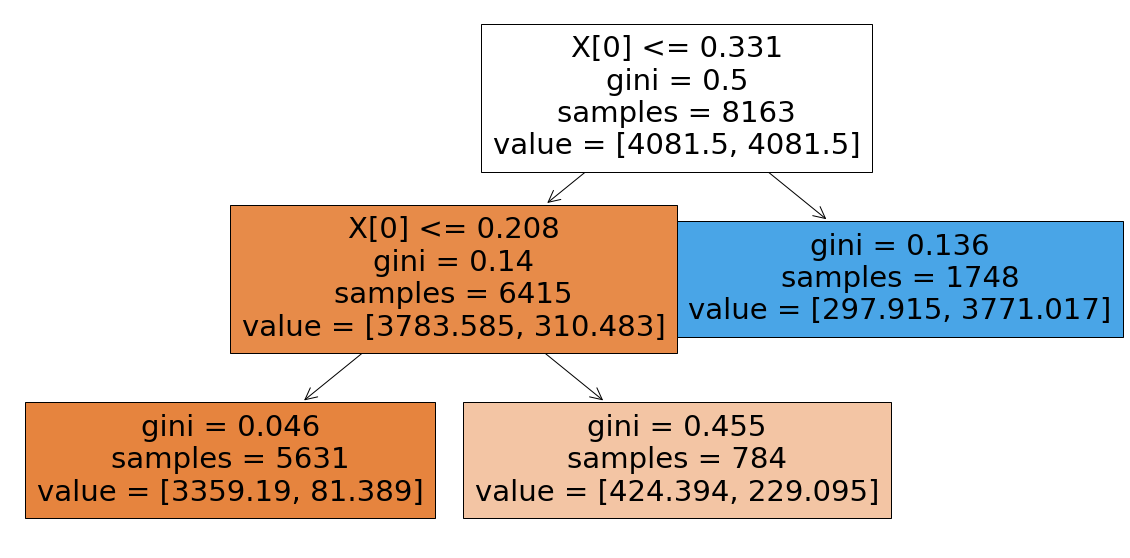

In [27]:
plt.figure(figsize=(20,10)) 
plot_tree(classifier, filled=True) 
plt.show()

In [28]:
dict = {}
for p in predicted:
    for t in predicted[p]['turns']:
        dict[p + '-' + str(t['turn-index'])]= t['labels'][0]['breakdown']
json.dumps(dict)

'{"084bd95c-cfd9-4bd3-8d2f-a7ce0ff1147d-2": "O", "084bd95c-cfd9-4bd3-8d2f-a7ce0ff1147d-4": "O", "084bd95c-cfd9-4bd3-8d2f-a7ce0ff1147d-6": "O", "084bd95c-cfd9-4bd3-8d2f-a7ce0ff1147d-8": "O", "084bd95c-cfd9-4bd3-8d2f-a7ce0ff1147d-10": "O", "084bd95c-cfd9-4bd3-8d2f-a7ce0ff1147d-12": "O", "084bd95c-cfd9-4bd3-8d2f-a7ce0ff1147d-14": "X", "084bd95c-cfd9-4bd3-8d2f-a7ce0ff1147d-16": "O", "00094a5b-939c-4f6e-8548-c0c3c375e2bd-2": "X", "00094a5b-939c-4f6e-8548-c0c3c375e2bd-4": "X", "00102824-a5ec-44f4-b0af-4ae49b53fc96-2": "O", "00102824-a5ec-44f4-b0af-4ae49b53fc96-4": "X", "00102824-a5ec-44f4-b0af-4ae49b53fc96-6": "O", "00102824-a5ec-44f4-b0af-4ae49b53fc96-8": "O", "00102824-a5ec-44f4-b0af-4ae49b53fc96-10": "O", "00102824-a5ec-44f4-b0af-4ae49b53fc96-12": "O", "00102824-a5ec-44f4-b0af-4ae49b53fc96-14": "O", "08819310-eeb8-4637-ab1c-7438da284a76-2": "O", "08819310-eeb8-4637-ab1c-7438da284a76-4": "O", "08819310-eeb8-4637-ab1c-7438da284a76-6": "X", "08819310-eeb8-4637-ab1c-7438da284a76-8": "O", "088

### Treino

In [ ]:
from tqdm import tqdm
import numpy as np

def build_pipeline(params):
    pipeline = sklearn.pipeline.Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('user-utterance', Pipeline([
                ('selector', ItemSelector(key='user-utterance')),
                ('tfidf', TfidfVectorizer(min_df=params['tfidf__min_df'],
                                          max_df=params['tfidf__max_df'],
                                          ngram_range=(1,2))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999, random_state=0)),
            ])),

            ('system-utterance', Pipeline([
                ('selector', ItemSelector(key='system-utterance')),
                ('tfidf', TfidfVectorizer(min_df=params['tfidf__min_df'],
                                          max_df=params['tfidf__max_df'],
                                          ngram_range=(1,2))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999, random_state=0)),
            ])),
            
            ('user-utterance-vector', Pipeline([
                #('selector', ItemSelector(key='user-utterance-tail'))
                ('userWindowSelector', WindowItemSelector(key='user-bert',
                                                          conversationKey='dialogue-id',
                                                          windowSize=params['windowSize']))
                ,('pca',PCA(0.999, random_state=0))
                #,('W2VecSelector', EmbeddingVectorizer())
            ])),
            
            ('system-utterance-vector', Pipeline([
                #('selector', ItemSelector(key='system-utterance-tail'))
                ('systemWindowSelector', WindowItemSelector(key='system-bert',
                                                            conversationKey='dialogue-id',
                                                            windowSize=params['windowSize']))
                ,('pca',PCA(0.999, random_state=0))
                #,('W2VecSelector', EmbeddingVectorizer())
            ]))

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'user-utterance': 1.0,
            'system-utterance': 1.0,
            'user-utterance-tail': 1.0,
            'system-utterance-tail': 1.0,
            'user-turn': 1.0,
            'system-turn':1.0,
            'kernel':'linear',
            'probability':True
        },
    )),
    ('clf', GBR(n_estimators=params['gbr__n_estimators'],
                learning_rate=params['gbr__learning_rate'],
                max_depth=params['gbr__max_depth'],
                random_state=0))])
    
    return pipeline

from sklearn.tree import DecisionTreeClassifier, plot_tree

N_ITER = 100

best_model = None
best_classifier = None
best_result = -np.inf
tuned_parameters = None

for i in tqdm(range(N_ITER)):
    parameters = {
        'windowSize': np.random.randint(low=3, high=11),
        'tfidf__min_df': np.random.randint(low=2, high=6),
        'tfidf__max_df': np.random.uniform(low=0.9, high=1.0),
        'gbr__n_estimators': np.random.randint(low=15, high=150),
        'gbr__learning_rate': np.random.choice(np.logspace(-3, -1, 5)),
        'gbr__max_depth': np.random.randint(low=3, high=6)
    }
    print(parameters)
    pipeline = build_pipeline(parameters)
    pipeline.fit(train, train['class'])
    
    trainPred = pipeline.predict(train)
    testPred = pipeline.predict(test)
    
    classifier = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=3, class_weight="balanced", random_state=0)
    classifier.fit(trainPred.reshape(-1,1),train['class'].astype(str).values.reshape(-1,1))
    trainPred2 = classifier.predict(trainPred.reshape(-1,1))
    testPred2 = classifier.predict(testPred.reshape(-1,1))
    
    predicted = resultArray(classifier, test, testPred.reshape(-1,1))
    output = evaluationAsDict(eval_data_path,predicted,0)
    
    if output['f1X']>best_result:
        best_result = output['f1X']
        best_model = pipeline
        best_classifier = classifier
        tuned_parameters = parameters

print(tuned_parameters)

testPred = best_model.predict(test)
predicted = resultArray(best_classifier, test, testPred.reshape(-1,1))
output = evaluationAsDict(eval_data_path,predicted,0)